In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [2]:
from google.colab import files
uploaded= files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [3]:
df= pd.read_excel('Airlines+Data.xlsx')
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [4]:
df1=df.copy()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [6]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


In [7]:
df1.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [8]:
df1.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [9]:
df1 = df1.set_index('Month')

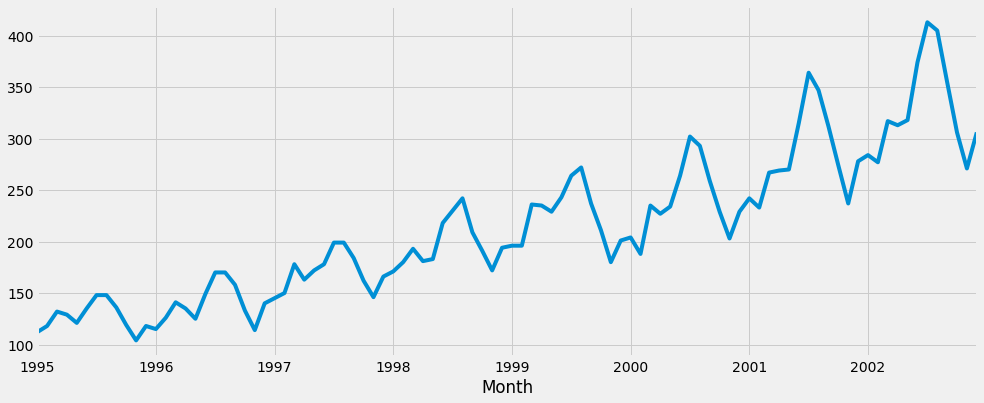

In [10]:
df1['Passengers'].plot(figsize=(15, 6))
plt.show()

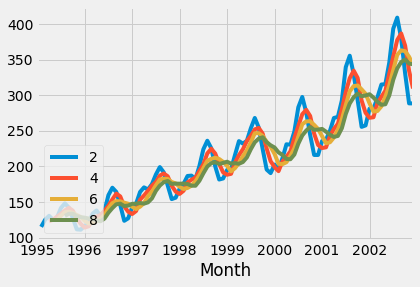

In [11]:
for i in range(2,10,2):
    df1['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

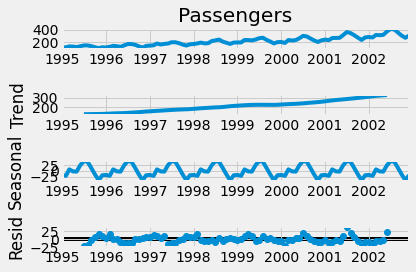

In [12]:
ts_add = seasonal_decompose(df1['Passengers'],model="additive")
fig = ts_add.plot()
plt.show()

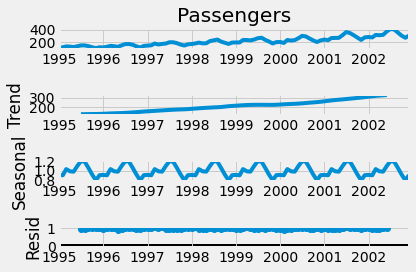

In [13]:
ts_mul = seasonal_decompose(df1.Passengers,model="multiplicative")
fig = ts_mul.plot()
plt.show()

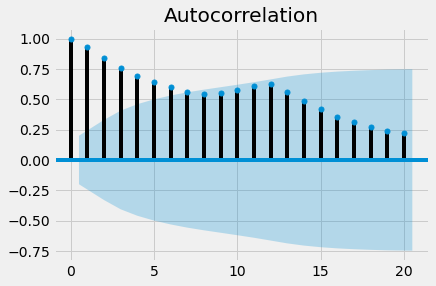

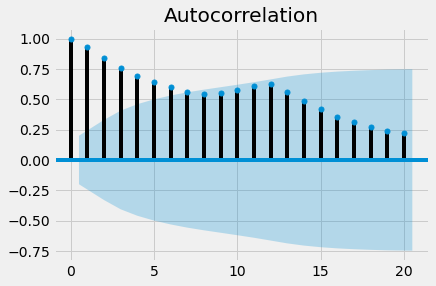

In [14]:
tsa_plots.plot_acf(df1['Passengers'])

In [36]:
temp=pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

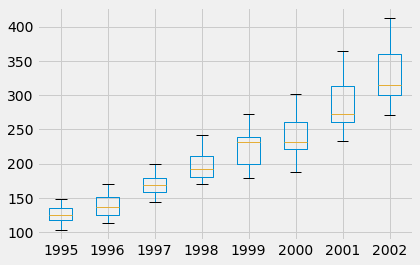

In [37]:
group=temp.groupby(pd.Grouper(freq='A'))
years=pd.DataFrame()
for i,j in group:
    years[i.year]=j.values
years.boxplot()
plt.show()

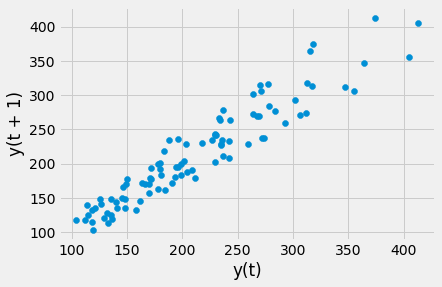

In [39]:
from pandas.plotting import lag_plot
lag_plot(temp)

**Performing the data driven methods on the dataset**

Train and test split on the data

In [41]:
train = df.head(77)
test = df.tail(19)

Moving Average and time decomposition plot

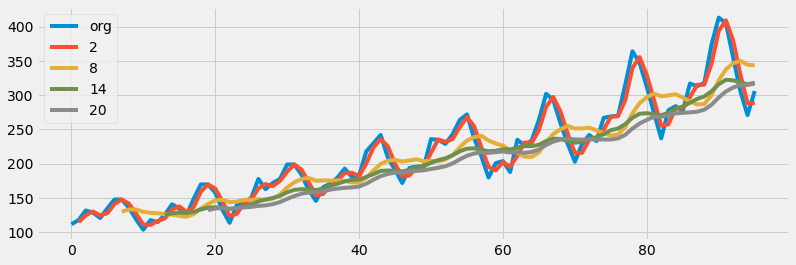

In [42]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
for i in range(2,24,6):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

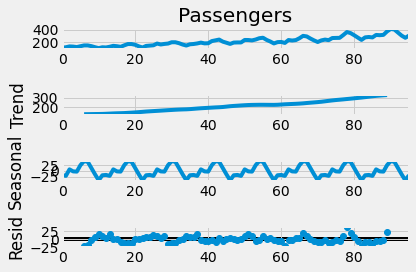

In [44]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

**ACF plots and PACF plots to identify the significant features that contribute to forecast**

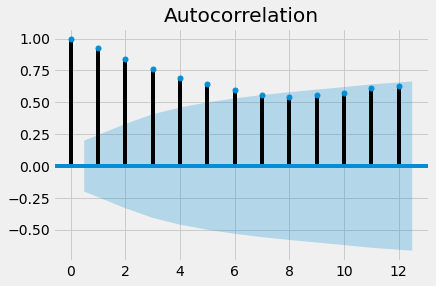

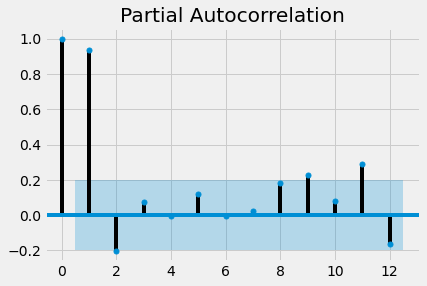

In [46]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Passengers,lags=12)
tsa_plots.plot_pacf(df.Passengers,lags=12)
plt.show()

Creating a user defined function to calculate the RMSE value

In [47]:
def RMSE(pred,org):
    temp = (np.sqrt(np.mean((np.array(org)-np.array(pred))**2)))
    return temp

Developing a data driven model - Simple exponential method

In [48]:
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
r1=RMSE(pred_ses,test.Passengers) 
r1

80.54332901444305

### Developing a data driven model - Holt's model

In [49]:
# Holt method 
hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
r2=RMSE(pred_hw,test.Passengers) 
r2

47.877728640303836

Developing a data driven model - Holts winter exponential smoothing with additive seasonality and additive trend

In [50]:
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
r3=RMSE(pred_hwe_add_add,test.Passengers) 
r3

35.89148606488649

Developing a data driven model - Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [51]:
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
r4=RMSE(pred_hwe_mul_add,test.Passengers)
r4

30.903498240372365

**Consolidating the results**

In [52]:
t={"model":pd.Series(['Simple exponential','Holts model','Holts-add seas,add trend','holts-mul sea,add trend']),
   "RMSE":[r1,r2,r3,r4] }

In [53]:
t=pd.DataFrame(t)
t

,model,RMSE
0,Simple exponential,80.543329
1,Holts model,47.877729
2,"Holts-add seas,add trend",35.891486
3,"holts-mul sea,add trend",30.903498


**Creating a final model, to predict on the combined train and test dataset**

In [56]:
hwe_model_mul_add_new = ExponentialSmoothing(df["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()

**Forecasting for next 10 time periods**

In [57]:
hwe_model_mul_add_new.forecast(10)

96     312.899768
97     308.171843
98     355.533483
99     345.770653
100    345.697050
101    392.471899
102    436.502735
103    429.860677
104    380.174322
105    332.318746
dtype: float64

**Conclusion:
From the above models, the model with the lowest RMSE value is holts winter exponential smoothing with multiplicative seasonality and additive trend. Thus, we use it to forecast the airlines passengers using the same model**